In [1]:
import import_ipynb

import sys

import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams.update({'figure.max_open_warning': 0})
import matplotlib.ticker as mtick

from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test
kmf = KaplanMeierFitter()

import colorsys

import seaborn
seaborn.set(style='ticks')
from multiprocessing import Pool

from Dynamic_resistancelib import *

import scipy as sc
import numpy as np

print("Python version: ", sys.version)
print("numpy version: ", np.__version__)
print("matplotlib version: ", matplotlib.__version__)

importing Jupyter notebook from Dynamic_resistancelib.ipynb
importing Jupyter notebook from log_normal_truncated_ab.ipynb
Python version:  3.7.4 (default, Aug 13 2019, 15:17:50) 
[Clang 4.0.1 (tags/RELEASE_401/final)]
numpy version:  1.17.2
matplotlib version:  3.1.1


In [2]:
####-------------------------------------------------------------------------------------------------------####
#
# TKI pre CRT
#
####-------------------------------------------------------------------------------------------------------####

def Dynamic_TKIpreCRT_MetsDRRLRR_CoMorbid_local(i):

    # select index of model parameter (i.e. define patient)
    N0_total=GN0_total[i]
    N0_persister_frac=GN0_persister_frac[i]
    N0_resistance=GN0_resistance[i]
    r_sen=Gr_sen[i]
    r_per=Gr_per[i]
    r_res=Gr_res[i]
    beta=Gbeta[i]
    wkTKIset = G_wkTKIset[i] 
    
    h0=np.array([N0_total*(1-N0_persister_frac)-N0_resistance,N0_resistance,N0_total*N0_persister_frac])
    p_mutation = G_mu_set
    
    h0_local = h0
    h0_dist = (Gmet_scl)*h0
    h0 = (1+Gmet_scl)*h0
        
    # arrays to store results
    # total,local,distant
    cellSensTreated = np.zeros([18010,3]); #(30*12*5+1)*10
    cellPerTreated = np.zeros([18010,3]);
    cellResTreated = np.zeros([18010,3]);
    cellTotalTreated = np.zeros([18010,3]);    
    
    cellSensTreated[0,0] = h0[0];
    cellPerTreated[0,0] =  h0[2];
    cellResTreated[0,0] =  h0[1];
    cellTotalTreated[0,0] = np.sum(h0); 
    
    cellSensTreated[0,1] = h0_local[0];
    cellPerTreated[0,1] =  h0_local[2];
    cellResTreated[0,1] =  h0_local[1];
    cellTotalTreated[0,1] = np.sum(h0_local); 
    
    cellSensTreated[0,2] = h0_dist[0];
    cellPerTreated[0,2] =  h0_dist[2];
    cellResTreated[0,2] =  h0_dist[1];
    cellTotalTreated[0,2] = np.sum(h0_dist); 
    
    ####### TKI wkTKIset weeks #######
    
    # Vector of initial conditions
    y0 = 0
    doseErlotinibDaily = 150.0;
    # get plasma level for every timepoint
    
    # t definition of TIME
    # set up TKI daily dosing for pharmacokinetics 
    tInterval = 0.1
    tTKI = np.arange(tInterval, wkTKIset*7+tInterval/10, tInterval)
    daysTKI = wkTKIset*7  # Number of days to simulate 
    erlotinibStart = 0
    doseErlotinibDaily = 150.0;
    doseIntervalDaily = np.zeros(np.size(tTKI))+1;
    plasmadoseIntervalDaily = np.zeros(np.size(tTKI)+1);
    for tCounter in np.arange(erlotinibStart*10, (daysTKI)*10, 10): 
            doseIntervalDaily[int(tCounter)]=doseErlotinibDaily
            plasmadoseIntervalDaily[int(tCounter)]= 1.0182 + 0.0114*doseErlotinibDaily;    
    erlotinibPlasma=np.zeros(np.size(tTKI)+1)
    erlotinibPlasma[0]=y0

    # TKI treatment Loop 
    step=0;Cured=False;t_cure = 18000;
    for step in range(1,np.size(tTKI)+1):
        # Get dose for this step
        intTime = [0, 1]
        
        # Solve the Pharmacokinetic ODE
        erlotinib = sc.integrate.odeint(Pharmacokinetics, y0, intTime, args=(plasmadoseIntervalDaily[step], ))
        # Append result
        erlotinibPlasma[step]=erlotinib[0]
        # Update initial condition for next step
        y0 = [ float(erlotinib[1]), ]

        # Get dose for this step
        drugLevel = erlotinibPlasma[step]   
        
        # Solve the TKI ODEs
        cellsTreat_local = sc.integrate.odeint(EGFRkineticsGompertz_opt2, h0_local, intTime, args=(Vlimit, r_sen/10, r_res/10, r_per/10, p_mutation, beta,drugLevel))
        cellsTreat_dist = sc.integrate.odeint(EGFRkineticsGompertz_opt2, h0_dist, intTime, args=(Vlimit, r_sen/10, r_res/10, r_per/10, p_mutation, beta,drugLevel))

        # Extract number at the end of day
        # Append result
        cellSensTreated[step,:]=np.array([float(cellsTreat_local[1,0])+float(cellsTreat_dist[1,0]), float(cellsTreat_local[1,0]), float(cellsTreat_dist[1,0])])
        cellResTreated[step,:]= np.array([float(cellsTreat_local[1,1])+float(cellsTreat_dist[1,1]), float(cellsTreat_local[1,1]), float(cellsTreat_dist[1,1])])
        cellPerTreated[step,:]= np.array([float(cellsTreat_local[1,2])+float(cellsTreat_dist[1,2]), float(cellsTreat_local[1,2]), float(cellsTreat_dist[1,2])])

        #if a comparantent has <1 cell set compartment to 0
        cellSensTreated[step,cellSensTreated[step,:]<1]=0
        cellResTreated[step,cellResTreated[step,:]<1]=0
        cellPerTreated[step,cellPerTreated[step,:]<1]=0
        
        # Update initial condition for next step
        h0_local =  np.array([cellSensTreated[step,1], cellResTreated[step,1], cellPerTreated[step,1]])
        h0_dist =   np.array([cellSensTreated[step,2], cellResTreated[step,2], cellPerTreated[step,2]])
        h0 = h0_local+h0_dist
        
        cellTotalTreated[step,:]=cellSensTreated[step,:]+cellResTreated[step,:]+cellPerTreated[step,:]
        if cellTotalTreated[step,0]<1:
            Cured =True
            t_cure = step
            break
        
    ####### CRT 7 weeks #######
    
    Vinblastine_C0=5
    Cisplatin_C0=100
    current_alpha=Galpha[i]
    t_half=1
    
    next_step = np.size(tTKI)+1
    tCRT = np.arange(wkTKIset*7+tInterval,wkTKIset*7+7*7+tInterval/10, tInterval)
    days = np.round(np.arange(1.,50,tInterval),1)

    #only local in field cells affected by CRT
    #day will count from start of treatment
    if Cured==False:
        for step in range(next_step,next_step+np.size(tCRT)): 
            #5 weeks vinblastin + cisplatin
            if days[step-next_step]<36 and np.mod(days[step-next_step]+6,7)==0:
                Vinblastine_C=Vinblastine_C0;
                h0_local=h0_local*chemo(GVinblastine_u[i],Vinblastine_C);
                h0_dist=h0_dist*chemo(GVinblastine_u[i],Vinblastine_C);
            elif days[step-next_step]<36 and np.mod(days[step-next_step],1)==0:
                Vinblastine_C=Vinblastine_C0*(1./2)**((np.mod(days[step-next_step]-1,7))/t_half)  #decay
                h0_local=h0_local*chemo(GVinblastine_u[i],Vinblastine_C);
                h0_dist=h0_dist*chemo(GVinblastine_u[i],Vinblastine_C);
            if days[step-next_step]==1 or days[step-next_step]==29:
                Cisplatin_C=Cisplatin_C0;
                h0_local=h0_local*chemo(GCisplatin_u[i],Cisplatin_C);
                h0_dist=h0_dist*chemo(GCisplatin_u[i],Cisplatin_C);
            elif days[step-next_step]<50 and np.mod(days[step-next_step],1)==0:
                Cisplatin_C=Cisplatin_C0*(1./2)**((np.mod(days[step-next_step]-1,28))/t_half)  #decay
                h0_local=h0_local*chemo(GCisplatin_u[i],Cisplatin_C);
                h0_dist=h0_dist*chemo(GCisplatin_u[i],Cisplatin_C);
            
            # 60 Gy  2*30 - local only
            if (days[step-next_step]<42):
                if ((np.mod(days[step-next_step]+6,7)==0 or np.mod(days[step-next_step]+5,7)==0 or np.mod(days[step-next_step]+4,7)==0 or np.mod(days[step-next_step]+3,7)==0 or np.mod(days[step-next_step]+2,7)==0)):  
                    h0_local=h0_local*radiation(current_alpha,current_alpha/10,2)
         
            # Gompertz Growth + Mutation 
            intTime = [0, 1]
            cellsGrow_local = sc.integrate.odeint(GompertzMutation, h0_local, intTime, args=(Vlimit, r_sen/10, r_res/10, r_sen/10, p_mutation))        
            cellsGrow_dist  = sc.integrate.odeint(GompertzMutation, h0_dist, intTime, args=(Vlimit, r_sen/10, r_res/10, r_sen/10, p_mutation))        

            # Extract number at the end of day
            # Append result
            cellSensTreated[step,:]=np.array([float(cellsGrow_local[1,0])+float(cellsGrow_dist[1,0]), float(cellsGrow_local[1,0]), float(cellsGrow_dist[1,0])])
            cellResTreated[step,:]= np.array([float(cellsGrow_local[1,1])+float(cellsGrow_dist[1,1]), float(cellsGrow_local[1,1]), float(cellsGrow_dist[1,1])])
            cellPerTreated[step,:]= np.array([float(cellsGrow_local[1,2])+float(cellsGrow_dist[1,2]), float(cellsGrow_local[1,2]), float(cellsGrow_dist[1,2])])

            #if a comparantent has <1 cell set compartment to 0
            cellSensTreated[step,cellSensTreated[step,:]<1]=0
            cellResTreated[step,cellResTreated[step,:]<1]=0
            cellPerTreated[step,cellPerTreated[step,:]<1]=0
            
            # Update initial condition for next step
            h0_local =  np.array([cellSensTreated[step,1], cellResTreated[step,1], cellPerTreated[step,1]])
            h0_dist =   np.array([cellSensTreated[step,2], cellResTreated[step,2], cellPerTreated[step,2]])
            h0 = h0_local+h0_dist
            
            cellTotalTreated[step,:]=cellSensTreated[step,:]+cellResTreated[step,:]+cellPerTreated[step,:]
            if cellTotalTreated[step,0]<1:
                Cured =True
                t_cure = step
                break
                
    ####### regrowth after treatment if not cured or progression #######    
    steps_remaining = 18010-(step)
    if (Cured==False): 
        intTime = np.arange(0,steps_remaining,1)
        cellsGrow_local = sc.integrate.odeint(GompertzMutation, h0_local, intTime, args=(Vlimit, r_sen/10, r_res/10, r_sen/10, p_mutation))        
        cellsGrow_dist  = sc.integrate.odeint(GompertzMutation, h0_dist, intTime, args=(Vlimit, r_sen/10, r_res/10, r_sen/10, p_mutation))        
        cellSensTreated[step+1:18010,:]=np.transpose(np.array([(cellsGrow_local[1:,0])+(cellsGrow_dist[1:,0]), (cellsGrow_local[1:,0]), (cellsGrow_dist[1:,0])]))
        cellResTreated[step+1:18010,:]= np.transpose(np.array([(cellsGrow_local[1:,1])+(cellsGrow_dist[1:,1]), (cellsGrow_local[1:,1]), (cellsGrow_dist[1:,1])]))
        cellPerTreated[step+1:18010,:]= np.transpose(np.array([(cellsGrow_local[1:,2])+(cellsGrow_dist[1:,2]), (cellsGrow_local[1:,2]), (cellsGrow_dist[1:,2])]))
        cellTotalTreated[step+1:18010,:] = cellSensTreated[step+1:18010,:]+cellResTreated[step+1:18010,:]+cellPerTreated[step+1:18010,:]

    ####### Comorbid Sample Russian Roullete #######    
    comorbidRate = 1-(.288/(.113+.288))**(1/60) #0.0055 mo^{-1}
    r = np.random.uniform(0,1,1)
    T_Mo_comorbid = (np.log(-(r-1))/np.log(1-comorbidRate)) 
        
    ####### find when patient dies and tumor progression ####### 
    # death or cure cancer
    if cellTotalTreated[18000,0]> EndT:
        ind_Tdeath=next(i for i,v in enumerate(cellTotalTreated[:,0]) if v > EndT)
        T_Mo_death = ind_Tdeath/10/30
        T_Mo_cure = 60    
    elif Cured:
        T_Mo_cure = t_cure/10/30
        T_Mo_death = 60
    else:
        T_Mo_death = 60
        T_Mo_cure = 60
    
    # compare death or cure to randomly sampled comorbid
    if (T_Mo_comorbid<60) & (T_Mo_comorbid<T_Mo_death):
        T_Mo_death = T_Mo_comorbid
        T_Mo_cure = 60
           
    # find local and distant failures every 3 mo.
    if cellTotalTreated[18000,1]> N0_total:
        ind_LRR_3mo=next(i for i,v in enumerate(cellTotalTreated[900:18010:900,1]) if v > N0_total)  
        T_Mo_LRR_3mo = (ind_LRR_3mo*900+900)/10/30    
    else:
        T_Mo_LRR_3mo = 60        
    if cellTotalTreated[18000,2]> G_DRRlvl:
        ind_DRR_3mo=next(i for i,v in enumerate(cellTotalTreated[900:18010:900,2]) if v > G_DRRlvl)  
        T_Mo_DRR_3mo = (ind_DRR_3mo*900+900)/10/30    
    else:
        T_Mo_DRR_3mo = 60        
    
    T_prog = np.min([T_Mo_death,T_Mo_LRR_3mo,T_Mo_DRR_3mo])          

    out_PR = np.zeros(3)
    out_PR[0] = T_Mo_LRR_3mo; out_PR[1] = T_Mo_DRR_3mo; out_PR[2] = T_prog;
    
    return out_PR

In [3]:
if __name__ == '__main__':
    
####-------------------------------------------------------------------------------------------------------####
#                                                                                                             #
#   Calibrate Model Parameters                                                                                #
#                                                                                                             #
####-------------------------------------------------------------------------------------------------------####   
   
    mu_t3a =             1.914964   #stage IIIa [cm] diameter mean tumor from Geng et al.
    sig_t3a =            0.9399669  #stage IIIa [cm] diameter standard dev. tumor from Geng et al.
    mu_t3b =             2.764675   #stage IIIb [cm] diameter mean tumor from Geng et al.
    sig_t3b =            0.6871617  #stage IIIb [cm] diameter standard dev. tumor from Geng et al.
    mu_t4 =              3.869198   #stage IV [cm] diameter mean tumor from Geng et al.
    sig_t4 =             0.8822491  #stage IV [cm] diameter standard dev tumor from Geng et al.
    mu_row =             7e-05      #growth parameter [day ^-1] mean from Geng et al.
    capacity =           30         #carrying capacity [cm] diameter tumor from Geng et al.
    V_Death =            13         #death inducing [cm] diameter tumor from Geng et al.(not used in this study)

    #Chemo parameters from Geng et al.
    Vinblastine_u_mu =   0.02819574 
    Vinblastine_u_sig =  0.00068308 
    cisplatin_u_mu =     0.02819574
    cisplatin_u_sig =    0.00068308
    
    # Set Global Variables Which Will Be Called in Each Treatment Function
    global Galpha,Vlimit,EndT,GVinblastine_u,Gcisplatin_u,\
    G_mu_set,GN0_total,GN0_persister_frac,GN0_resistance,Gr_sen,Gr_per,Gr_res,Gbeta,G_wkTKIset,Gmet_scl,G_DRRlvl
    
    Vlimit=5.8e8*4/3*np.pi*(capacity/2)**3; #carrying capacity spherical tumor vol. from Geng et al.
    EndT=5.8e8*4/3*np.pi*(V_Death/2)**3; #death inducing spherical tumor vol. from Geng et al. (not used in this study)

    ###########################################################################################
    ####### Model Parameters to Calibrate Over                                          #######
    ###########################################################################################
    met_scl = np.array([0.25e-6,0.5e-6,0.75e-6,1e-6,1.5e-6,2e-6,2.5e-6,3e-6,3.5e-6,4e-6,5e-6])
    sig_row_var = np.arange(0.003,0.0085,0.0005)
    alpha_mu_var = np.arange(0.04,.3,0.02)    
    alpha_sig_var = np.append(np.arange(0.1,0.2,0.01),np.arange(0.2,.51,0.03))
    ###########################################################################################
    
    #pre defined model params
    num_months = 60                         # simulated months (5 Yrs)
    n_sample = 16                           # number of simulated patients, must be divisible by two for bootstrapping
    initResFrac = [0.0001,0.001,0.01,0.1]   #initial resistant fractions
    initPerFrac = [0.05, 0.2, 0.5]          #initial persistant fractions
    wk_TKI_Induction = [0,1,2,4,8,12,16]    #various inductions lengths
    G_mu_set = 1e-07                        # per -> res transition param
    G_DRRlvl = 5.8e8                        # 1cc distant compartment detection limit 
 
    ###### create truncated log-normal and truncated normal parameter distributions ######
    # create initial stage III size distribution
    Stest_InitialDiameters=np.zeros(n_sample)
    S3a_InitialDiameters=Gettrunclognorm(mu=mu_t3a,sig=sig_t3a,lower = 0.3, upper=V_Death,num=n_sample); 
    S3b_InitialDiameters=Gettrunclognorm(mu=mu_t3b,sig=sig_t3b,lower = 0.3, upper=V_Death,num=n_sample);  
    # from PROCLAIM trial -> 47% of patients had stage IIIa and 53% had stage IIIb 
    # we hueristically create a similar stage III size distribution
    temps=np.random.uniform(0,1,size=n_sample);
    for ns in range(n_sample): 
        if temps[ns]<0.47:
            Stest_InitialDiameters[ns]=S3a_InitialDiameters[ns]; 
        else:
            Stest_InitialDiameters[ns]=S3b_InitialDiameters[ns];

    # create chemo and radiation parameter distributions
    GVinblastine_u=Gettruncnorm(mu=Vinblastine_u_mu,sig=Vinblastine_u_sig,lower = 0, upper=np.inf,num=n_sample);
    GCisplatin_u=Gettruncnorm(mu=cisplatin_u_mu,sig=cisplatin_u_sig,lower = 0, upper=np.inf,num=n_sample); 
    
    ##############################################################################
    #####                   Run Calibration Simulations                      #####
    ##### (note this can take very long, time with small number of patients) #####
    ##############################################################################
    
    #set induction length(note CRT only is TKI induction length of 0 with no maintenance)
    G_wkTKIset=wk_TKI_Induction[0]*np.ones(n_sample);

    #set initial tumor distribution to stage III for CRT only treatments
    GN0_total = 5.8e8*4/3*np.pi*(Stest_InitialDiameters/2)**3
    GN0_persister_frac = initPerFrac[1]*np.ones(n_sample)
    GN0_resistance = initResFrac[2]*GN0_total
    # create TKI cell kill beta distribution
    Gbeta = Gettruncnorm(mu=2,sig=7,lower=1, upper=np.inf,num=n_sample)
    
    ##############################################################################              
    # Run Calibration Simulations for Growth_Sig and Initial Met Scalar Fraction
    ############################################################################## 
    alphaMuStrt = 5 #starting alpha mu parameter 
    alphaSigStrt = 3 #starting alpha sig parameter
    calc_MetSclRhoSig = False #change to True to run simulations
    if calc_MetSclRhoSig:
        for iiter in range(5):
            Galpha=Gettruncnorm(mu=alpha_mu_var[alphaMuStrt],sig=alpha_sig_var[alphaSigStrt],lower = 0, upper=np.inf,num=n_sample);
            for imet in range(len(met_scl)):
                for irho_sig in range(len(sig_row_var)):
                    Gr_sen = Gettruncnorm(mu=mu_row,sig=sig_row_var[irho_sig],lower = 0, upper=np.inf,num=n_sample);
                    Gr_per = Gr_sen/4
                    Gr_res = Gr_sen;
                    Gmet_scl = met_scl[imet]
                    
                    PatientResSave = np.zeros([n_sample,3])
                    for i in range(n_sample):
                        PatientResSave[i,:]=Dynamic_TKIpreCRT_MetsDRRLRR_CoMorbid_local(i) 
                    np.savetxt('ModelCalibration/DRR_rhosig_metScl/PatRes_iter{0}_metscl{1}_rhosig{2}_alphasig{3}_alphamu{4}.csv'.format(iiter,imet,irho_sig,alphaSigStrt,alphaMuStrt),PatientResSave, delimiter=',');
                            
    ################################################################################               
    # Run Calibration Simulations for Radiation Alpha_Sig and Alpha_Mu for Wild Type
    ################################################################################  
    metOpt = 5 #optimal metastatic fraction determined in next analysis section
    rhoSigOpt = 5 #optimal growth sigma  determined in next analysis section
    calc_MetSclRhoSig = False #change to True to run simulations
    if calc_MetSclRhoSig:
        for iiter in range(5):
            for ialpha_mu in range(10):
                for ialpha_sig in range(11):
                    Galpha=Gettruncnorm(mu=alpha_mu_var[ialpha_mu],sig=alpha_sig_var[ialpha_sig],lower = 0, upper=np.inf,num=n_sample);

                    Gr_sen = Gettruncnorm(mu=mu_row,sig=sig_row_var[rhoSigOpt],lower = 0, upper=np.inf,num=n_sample);
                    Gr_per = Gr_sen/4
                    Gr_res = Gr_sen;
                    Gmet_scl = met_scl[metOpt]

                    PatientResSave = np.zeros([n_sample,3])
                    for i in range(n_sample):
                        PatientResSave[i,:]=Dynamic_TKIpreCRT_MetsDRRLRR_CoMorbid_local(i)
                    np.savetxt('ModelCalibration/LRR_alphasig_alpharho/PatRes_iter{0}_metscl{1}_rhosig{2}_alphasig{3}_alphamu{4}.csv'.format(iiter,metOpt,rhoSigOpt,ialpha_sig,ialpha_mu),PatientResSave, delimiter=',');
    
    ################################################################################               
    # Run Calibration Simulations for Radiation Alpha_Sig and Alpha_Mu for EGFR mut
    ################################################################################  
    metOpt = 5 #optimal metastatic fraction determined in next analysis section
    rhoSigOpt = 5 #optimal growth sigma  determined in next analysis section
    calc_MetSclRhoSig = False #change to True to run simulations
    if calc_MetSclRhoSig:
        for iiter in range(5):
            for ialpha_mu in range(3,len(alpha_mu_var)):
                for ialpha_sig in range(10,len(alpha_sig_var)):
                    Galpha=Gettruncnorm(mu=alpha_mu_var[ialpha_mu],sig=alpha_sig_var[ialpha_sig],lower = 0, upper=np.inf,num=n_sample);

                    Gr_sen = Gettruncnorm(mu=mu_row,sig=sig_row_var[rhoSigOpt],lower = 0, upper=np.inf,num=n_sample);
                    Gr_per = Gr_sen/4
                    Gr_res = Gr_sen;
                    Gmet_scl = met_scl[metOpt]

                    PatientResSave = np.zeros([n_sample,3])
                    for i in range(n_sample):
                        PatientResSave[i,:]=Dynamic_TKIpreCRT_MetsDRRLRR_CoMorbid_local(i)
                    np.savetxt('ModelCalibration/LRR_EGFR_alphasig_alpharho/PatRes_iter{0}_metscl{1}_rhosig{2}_alphasig{3}_alphamu{4}.csv'.format(iiter,metOpt,rhoSigOpt,ialpha_sig,ialpha_mu),PatientResSave, delimiter=',');
                                              

importing Jupyter notebook from log_normal.ipynb
importing Jupyter notebook from r8_uniform_ab.ipynb
importing Jupyter notebook from normal.ipynb
importing Jupyter notebook from normal_01.ipynb
importing Jupyter notebook from r8poly_value_horner.ipynb


In [4]:
####-------------------------------------------------------------------------------------------------------####
#                                                                                                             #
#   Load Literature Calibration Data                                                                          #
#                                                                                                             #
####-------------------------------------------------------------------------------------------------------####   

LRR_I   = np.genfromtxt('LiteratureData/EGFR_LRR_DRR_Analysis/EGFR_I_Fig_LRR_WT_MUT.csv', delimiter=',')
DRR_I   = np.array([[24,1-0.617],[24,1-0.637]])
LRR_II  = np.genfromtxt('LiteratureData/EGFR_LRR_DRR_Analysis/EGFR_II_Fig_LRR_WT_MUT.csv', delimiter=',')
DRR_II  = np.genfromtxt('LiteratureData/EGFR_LRR_DRR_Analysis/EGFR_II_Fig_DRR_WT_MUT.csv', delimiter=',')
LRR_III = np.genfromtxt('LiteratureData/EGFR_LRR_DRR_Analysis/EGFR_III_Fig_LRR_WT_MUT.csv', delimiter=',')
DRR_III = np.genfromtxt('LiteratureData/EGFR_LRR_DRR_Analysis/EGFR_III_Fig_DRR_WT_MUT.csv', delimiter=',')

N_WT = [94,69,155]
N_MUT = [24,26,29]

Trial_LRR = ( N_WT[0]*LRR_I[0:4,1] + N_MUT[0]*LRR_I[4:9,1] + N_WT[1]*LRR_II[0:4,1] + N_MUT[1]*LRR_II[4:9,1] + N_WT[2]*LRR_III[0:4,1] + N_MUT[2]*LRR_III[4:9,1] )/ (np.sum(N_WT) + np.sum(N_MUT))
Trial_LRR_EGFR = (N_MUT[0]*LRR_I[4:9,1] + N_MUT[1]*LRR_II[4:9,1] + N_MUT[2]*LRR_III[4:9,1] )/ (np.sum(N_MUT))
Trial_DRR =  ( N_WT[1]*DRR_II[0:4,1] + N_MUT[1]*DRR_II[4:9,1] + N_WT[2]*DRR_III[0:4,1] + N_MUT[2]*DRR_III[4:9,1] )/ (np.sum(N_WT[1:3]) + np.sum(N_MUT[1:3]))
Trial_DRR[1] = (N_WT[0]*DRR_I[0,1] + N_MUT[0]*DRR_I[1,1] + Trial_DRR[1]*(np.sum(N_WT[1:3]) + np.sum(N_MUT[1:3])) )/(np.sum(N_WT) + np.sum(N_MUT))
Trial_T= [12,24,36,48]

Trial_LRR_I = (N_WT[0]*LRR_I[0:4,1] + N_MUT[0]*LRR_I[4:9,1])/(N_WT[0] + N_MUT[0])
Trial_LRR_EGFR_I = LRR_I[4:9,1]
Trial_DRR_I = [np.nan,np.nan,np.nan,np.nan]
Trial_DRR_I[1] = (N_WT[0]*DRR_I[0,1] + N_MUT[0]*DRR_I[1,1])/(N_WT[0] + N_MUT[0])

Trial_LRR_II = (N_WT[1]*LRR_II[0:4,1] + N_MUT[1]*LRR_II[4:9,1])/(N_WT[1] + N_MUT[1])
Trial_LRR_EGFR_II = LRR_II[4:9,1]
Trial_DRR_II = (N_WT[1]*DRR_II[0:4,1] + N_MUT[1]*DRR_II[4:9,1])/(N_WT[1] + N_MUT[1])

Trial_LRR_III = (N_WT[2]*LRR_III[0:4,1] + N_MUT[2]*LRR_III[4:9,1])/(N_WT[2] + N_MUT[2])
Trial_LRR_EGFR_III = LRR_III[4:9,1]
Trial_DRR_III = (N_WT[2]*DRR_III[0:4,1] + N_MUT[2]*DRR_III[4:9,1])/(N_WT[2] + N_MUT[2])

'metOpt = [5]'

'rhoSigOpt = [5]'

<Figure size 432x432 with 0 Axes>

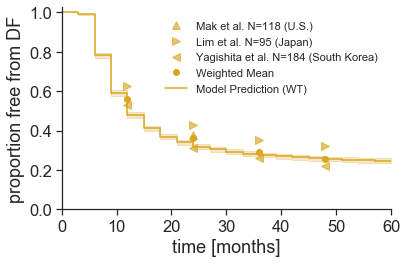

<Figure size 432x432 with 0 Axes>

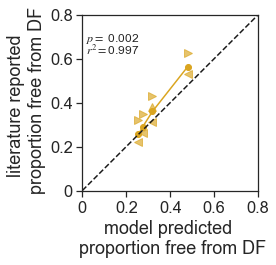

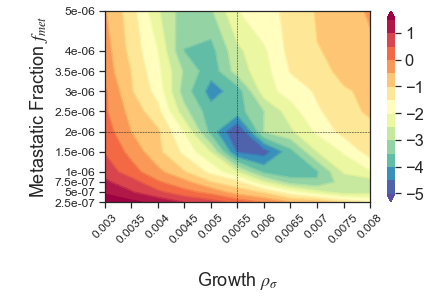

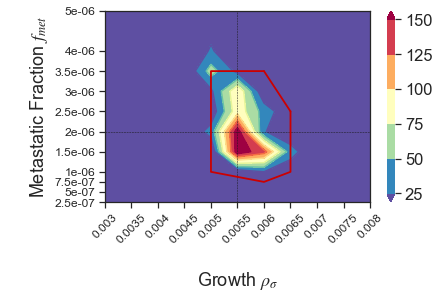

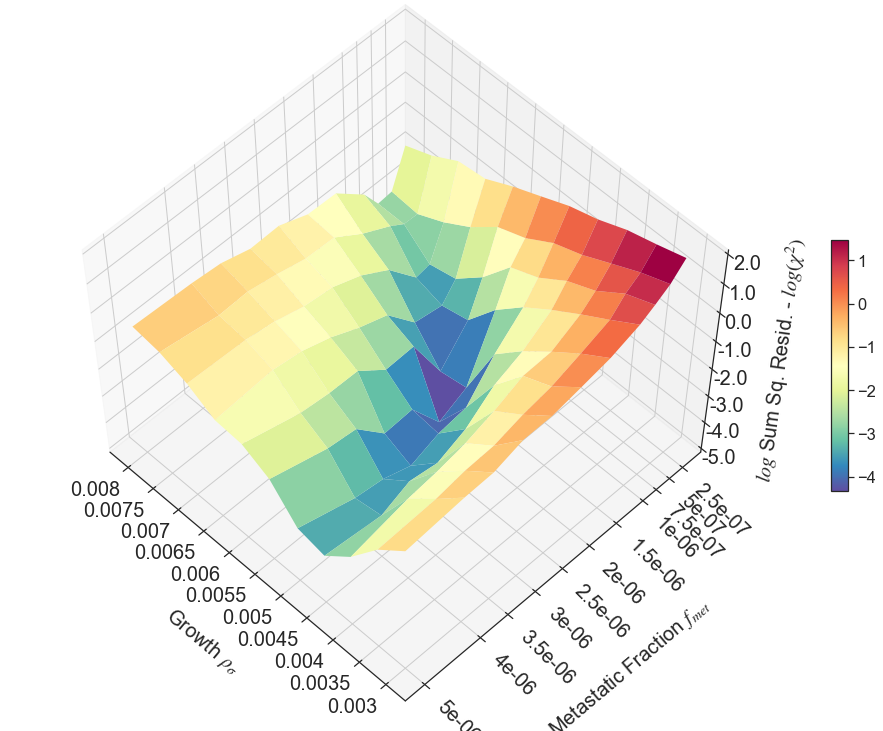

<Figure size 432x432 with 0 Axes>

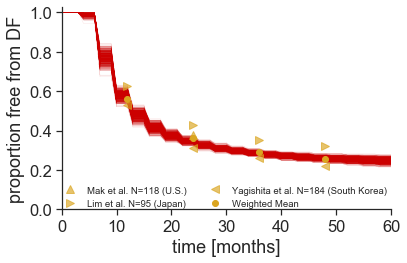

In [5]:
####-------------------------------------------------------------------------------------------------------####
#                                                                                                             #
#   Analyze Calibration Simulations                                                                           #
#                                                                                                             #
####-------------------------------------------------------------------------------------------------------####   

####################### Load Model Calibration Data ##################################
# this will produce paper figures
# change to 'ModelCalibration' to load data generated above in _FirstCalibrate
pth = 'PaperCalibration'  #'PaperCalibration' will load data to creat figures in paper
n_sample=1024 # must be divisible by two
######################################################################################

# create data arrays to load the calibration simulations
ChiSq_DRR_fitMetRho = np.zeros([len(met_scl),len(sig_row_var)])
ChiSq_DRR_fitMetRho1000 = np.zeros([len(met_scl),len(sig_row_var),1000])
All_DRR_fitMetRho1000 = np.zeros([len(met_scl),len(sig_row_var),1000,num_months+1])
    
ChiSq_LRR_fitAlpha = np.zeros([10,11])
ChiSq_LRR_fitAlpha1000 = np.zeros([10,11,1000])
All_LRR_fitAlpha1000 = np.zeros([10,11,1000,num_months+1])

ChiSq_LRR_fitAlphaEGFR = np.zeros([len(range(3,len(alpha_mu_var))),len(range(10,len(alpha_sig_var)))])
ChiSq_LRR_fitAlphaEGFR1000 = np.zeros([len(range(3,len(alpha_mu_var))),len(range(10,len(alpha_sig_var))),1000])
All_LRR_fitAlphaEGFR1000 = np.zeros([len(range(3,len(alpha_mu_var))),len(range(10,len(alpha_sig_var))),1000,num_months+1])

# generate the 1000 random indexes for boostrapping 
arr = np.arange(5*n_sample)
index1000 = np.zeros([5*n_sample,1000])
for iiter in range(1000):
    np.random.shuffle(arr)        
    index1000[:,iiter] = arr

##############################################################################              
# Analyze Calibration Simulations for Growth_Sig and Initial Met Scalar Fraction
############################################################################## 
alphaMuStrt = 5 #starting alpha mu parameter 
alphaSigStrt = 3 #starting alpha sig parameter
plot_MetSclRhoSig = True # load data for plotting
if plot_MetSclRhoSig:
    PatientResSaveCoMor_All = np.zeros([5*n_sample,3])
    for imet in range(len(met_scl)):
        for irho_sig in range(len(sig_row_var)):
            for iiter in range(5):
                PatientResSaveCoMor = np.genfromtxt(pth+'/DRR_rhosig_metScl/PatRes_iter{0}_metscl{1}_rhosig{2}_alphasig{3}_alphamu{4}.csv'.format(iiter,imet,irho_sig,alphaSigStrt,alphaMuStrt), delimiter=',');
                PatientResSaveCoMor_All[iiter*n_sample:(iiter+1)*n_sample,:] = PatientResSaveCoMor
                
                DRR_comor = Calc_Cumulative_Curve(PatientResSaveCoMor_All[:,1])                    
                ChiSq_DRR_fitMetRho[imet,irho_sig] = np.sum(((DRR_comor[Trial_T]-Trial_DRR)/Trial_DRR)**2)
            
            # boot strapping confidence intervals
            # run 1000 iterations and radnomly sub-sample 1/10 of of samples (half of n_sample with 5 iterations, 512 in paper for 1024 samples*5 iteration = 5120 total)
            for iiter in range(1000):
                DRR_comor1000 = Calc_Cumulative_Curve(PatientResSaveCoMor_All[list(index1000[0:int(n_sample/2),iiter].astype(int)) ,1])                    
                All_DRR_fitMetRho1000[imet,irho_sig,iiter,:] = DRR_comor1000
                ChiSq_DRR_fitMetRho1000[imet,irho_sig,iiter] = np.sum(((DRR_comor1000[Trial_T]-Trial_DRR)/Trial_DRR)**2)
    
    # determine the global optimum parameter and load data for this parameter                           
    [metOpt,rhoSigOpt]=np.where(ChiSq_DRR_fitMetRho==np.min(ChiSq_DRR_fitMetRho))
    display('metOpt = {0}'.format(metOpt))
    display('rhoSigOpt = {0}'.format(rhoSigOpt))
    for iiter in range(5):
        PatientResSaveCoMor = np.genfromtxt(pth+'/DRR_rhosig_metScl/PatRes_iter{0}_metscl{1}_rhosig{2}_alphasig{3}_alphamu{4}.csv'.format(iiter,int(metOpt),int(rhoSigOpt),alphaSigStrt,alphaMuStrt), delimiter=',');
        PatientResSaveCoMor_All[iiter*n_sample:(iiter+1)*n_sample,:] = PatientResSaveCoMor
    
    # boot strapping 95% confidence intervals
    # find nearest 950 of 1000 iterations to global optimum and calculate convex hull
    Cendrr1000 = np.where(ChiSq_DRR_fitMetRho==np.min(ChiSq_DRR_fitMetRho))                 
    Distdrr1000 = np.zeros([1000,1])
    drr1000 = np.zeros([1000,2])
    for iiter in range(1000):
        ind = np.where(ChiSq_DRR_fitMetRho1000[:,:,iiter]==np.min(ChiSq_DRR_fitMetRho1000[:,:,iiter]))
        drr1000[iiter,0] = ind[0][0]
        drr1000[iiter,1] = ind[1][0]
        Distdrr1000[iiter] = np.sum((drr1000[iiter,:]-np.transpose(Cendrr1000))**2)**0.5
    indx = np.argsort(Distdrr1000,axis=0)
    points = np.transpose(np.array([sig_row_var[list(drr1000[:,1].astype(int))],np.array(met_scl)[list(drr1000[:,0].astype(int))]]))
    points95 = np.squeeze(points[indx[0:950],:])
    hull95 = sc.spatial.ConvexHull(points95)
    
    # K-P plot of model data at global optimum parameters
    plt.figure(figsize=[6,6])
    with seaborn.axes_style("ticks"):
        seaborn.set(style='ticks',font_scale=1.5)
        fig,ax = plt.subplots()
        plt.plot(Trial_T,Trial_DRR_I,'^',color='goldenrod',label='Mak et al. N=118 (U.S.)',alpha=0.66,markersize=8)
        plt.plot(Trial_T,Trial_DRR_II,'>',color='goldenrod',label='Lim et al. N=95 (Japan)',alpha=0.66,markersize=8)
        plt.plot(Trial_T,Trial_DRR_III,'<',color='goldenrod',label='Yagishita et al. N=184 (South Korea)',alpha=0.66,markersize=8)
        plt.plot(Trial_T,Trial_DRR,'o',color='goldenrod',label='Weighted Mean',markersize=6)
        kmf.fit(PatientResSaveCoMor_All[:,1],event_observed=PatientResSaveCoMor_All[:,1]<60,label='Model Prediction (WT)',alpha=1-0.95)
        ax = kmf.plot(ax=ax,color = 'goldenrod')
        plt.xlim([0,60])
        plt.ylim([0,1.025])
        ax.legend(loc=[0.3,0.55],prop={'size': 11.2},ncol=1,frameon=False)
        plt.xlabel('time [months]')
        plt.ylabel('proportion free from DF')
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        plt.tight_layout()  
    
    # Model data at global optimum parameters vs Literature Data
    ModVsTrial_DRR = np.zeros(4)
    for imo in range(4):
        ind = np.where(kmf.timeline>=(imo+1)*12)[0][0]
        ModVsTrial_DRR[imo]=np.array(kmf.survival_function_)[ind]
    slope, intercept, r_value, p_value, std_err = sc.stats.linregress(ModVsTrial_DRR, Trial_DRR)
    plt.figure(figsize=[6,6])
    with seaborn.axes_style("ticks"):
        seaborn.set(style='ticks',font_scale=1.5)
        fig,ax = plt.subplots()                            
        plt.plot(ModVsTrial_DRR,Trial_DRR,'o-',color = 'goldenrod')
        plt.plot(ModVsTrial_DRR,Trial_DRR_I,'^',color='goldenrod',alpha=0.66,markersize=8)
        plt.plot(ModVsTrial_DRR,Trial_DRR_II,'>',color='goldenrod',alpha=0.66,markersize=8)
        plt.plot(ModVsTrial_DRR,Trial_DRR_III,'<',color='goldenrod',alpha=0.66,markersize=8)
        plt.plot([0,0.8],[0,0.8],'k--')
        plt.xticks([0,0.2,0.4,0.6,0.8],[0,0.2,0.4,0.6,0.8])
        plt.yticks([0,0.2,0.4,0.6,0.8],[0,0.2,0.4,0.6,0.8])
        plt.xlabel('model predicted \n proportion free from DF')
        plt.ylabel('literature reported \n proportion free from DF')
        plt.text(0+0.6*0.025,0+0.8*0.775,'$r^2 =$' + str(round(r_value**2,3)),fontsize=12)
        plt.text(0+0.6*0.025,0+0.8*0.85,'$p =$ {0}'.format(round(p_value,3)),fontsize=12)
        plt.axis([0,0.8,0,0.8])
        ax.set_aspect('equal', 'box')
        plt.tight_layout()   
    
    # 2D countour of Chi Sq goodness of fit over entire model parameter space 
    Y = met_scl
    X = sig_row_var
    fig, ax = plt.subplots(figsize=[6.5,4.5])
    ax.plot([sig_row_var[int(rhoSigOpt)],sig_row_var[int(rhoSigOpt)]],[met_scl[0],met_scl[-1]],'--k',linewidth=0.5)
    ax.plot([sig_row_var[0],sig_row_var[-1]],[met_scl[int(metOpt)],met_scl[int(metOpt)]],'--k',linewidth=0.5)
    CS1=ax.contourf(X, Y, np.log(ChiSq_DRR_fitMetRho),np.arange(-5,2,0.5),cmap=cm.Spectral_r,extend='both')
    CS2=ax.contour(X, Y, np.log(ChiSq_DRR_fitMetRho),np.arange(-5,2,0.5),cmap=cm.Spectral_r,extend='both')
    cbar = plt.colorbar(CS1, ax=ax)
    cbar.outline.set_visible(False)
    ax.set_ylabel('\n'r'Metastatic Fraction $f_{met}$')
    ax.set_xlabel('\n'r'Growth $\rho_{\sigma}$') 
    ax.set_yticks(met_scl)
    ax.set_xticks(np.round(sig_row_var,4))
    ax.set_xticklabels(np.round(sig_row_var,4),rotation=45, fontsize=12)
    ax.set_yticklabels(met_scl,fontsize=12)
    fig.tight_layout() 
    
    # 2D histogram of optimal parameters and 95% convex hull (confidence interval)
    fig, ax = plt.subplots()
    hist2D = plt.hist2d(np.array(met_scl)[list(drr1000[:,0].astype(int))],sig_row_var[list(drr1000[:,1].astype(int))],[np.append(Y-0.0000001,max(Y)+0.0000001),np.append(X-0.0001,max(X)+0.0001)])
    plt.close()
    fig, ax = plt.subplots(figsize=[6.5,4.5])
    ax.plot([sig_row_var[int(rhoSigOpt)],sig_row_var[int(rhoSigOpt)]],[met_scl[0],met_scl[-1]],'--k',linewidth=0.5)
    ax.plot([sig_row_var[0],sig_row_var[-1]],[met_scl[int(metOpt)],met_scl[int(metOpt)]],'--k',linewidth=0.5)
    CS1=ax.contourf(X, Y,hist2D[0],np.arange(25,175,25),cmap=cm.Spectral_r,extend='both')
    CS2=ax.contour(X, Y, hist2D[0],np.arange(25,175,25),cmap=cm.Spectral_r,extend='both')
    ax.plot(points95[hull95.vertices,0], points95[hull95.vertices,1], '-',color=[0.8,0,0,1], lw=1.8);
    ax.plot([points95[hull95.vertices[len(hull95.vertices)-1],0],points95[hull95.vertices[0],0]], [points95[hull95.vertices[len(hull95.vertices)-1],1],points95[hull95.vertices[0],1]], '-', color=[0.8,0,0,1], lw=1.8)
    cbar = plt.colorbar(CS1, ax=ax)
    cbar.outline.set_visible(False)
    ax.set_ylabel('\n'r'Metastatic Fraction $f_{met}$')
    ax.set_xlabel('\n'r'Growth $\rho_{\sigma}$') 
    ax.set_yticks(met_scl[:])
    ax.set_xticks(np.round(sig_row_var,4))
    ax.set_xticklabels(np.round(sig_row_var,4),rotation=45, fontsize=12)
    ax.set_yticklabels(met_scl,fontsize=12)
    fig.tight_layout()
    
    # 3D surface of Chi Sq goodness of fit over entire model parameter space 
    fig = plt.figure(figsize=[14,10.5])
    ax = fig.gca(projection='3d')
    X, Y = np.meshgrid(X, Y)
    surf = ax.plot_surface(X, Y, np.log(ChiSq_DRR_fitMetRho), cmap=cm.Spectral_r,linewidth=0, antialiased=True)           
    ax.set_zlim(-5, 2)
    ax.set_xticks(sig_row_var)
    ax.set_yticks(met_scl)
    ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.2e'))
    plt.yticks(rotation=-45,horizontalalignment ='left')
    plt.xticks(horizontalalignment ='right')
    ax.set_xticklabels(np.round(sig_row_var,4), fontsize=20)
    ax.set_yticklabels(met_scl,fontsize=20)
    ax.set_zticklabels(np.arange(-5, 2.1,1),fontsize=20)    
    fig.colorbar(surf, shrink=0.35, aspect=15)
    ax.view_init(60, 135)
    ax.set_ylabel('\n'r'Metastatic Fraction $f_{met}$',linespacing=10,fontsize=20)
    ax.set_xlabel('\n'r'Growth $\rho_{\sigma}$',linespacing=6,fontsize=20) 
    ax.set_zlabel('\n'r'$log$ Sum Sq. Resid. - $log(\chi^{2})$',linespacing=3,fontsize=20) 
    plt.tight_layout() 
    
    # plot of 1000 radomly subsampled K-P curves
    plt.figure(figsize=[6,6])
    with seaborn.axes_style("ticks"):
        seaborn.set(style='ticks',font_scale=1.5)
        fig,ax = plt.subplots()
        for iiter in range(1000):
            plt.plot(All_DRR_fitMetRho1000[int(drr1000[iiter,0]),int(drr1000[iiter,1]),iiter,:],color=[0.8,0,0,1],linewidth = 1-0.95)
        plt.plot(Trial_T,Trial_DRR_I,'^',color='goldenrod',label='Mak et al. N=118 (U.S.)',alpha=0.66,markersize=8)
        plt.plot(Trial_T,Trial_DRR_II,'>',color='goldenrod',label='Lim et al. N=95 (Japan)',alpha=0.66,markersize=8)
        plt.plot(Trial_T,Trial_DRR_III,'<',color='goldenrod',label='Yagishita et al. N=184 (South Korea)',alpha=0.66,markersize=8)
        plt.plot(Trial_T,Trial_DRR,'o',color='goldenrod',label='Weighted Mean',markersize=6)
        plt.xlim([0,60])
        plt.ylim([0,1.025])
        ax.legend(loc=[-0.015,-0.015],prop={'size': 9.5},ncol=2,frameon=False)
        plt.xlabel('time [months]')
        plt.ylabel('proportion free from DF')
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        plt.tight_layout() 


'alphaMuOpt = [3]'

'alphaSigOpt = [7]'

<Figure size 432x432 with 0 Axes>

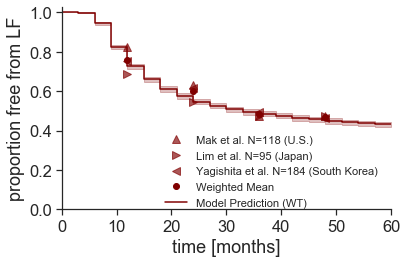

<Figure size 432x432 with 0 Axes>

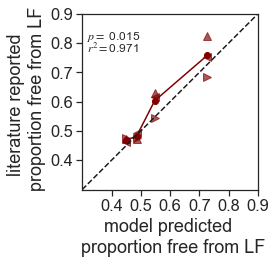

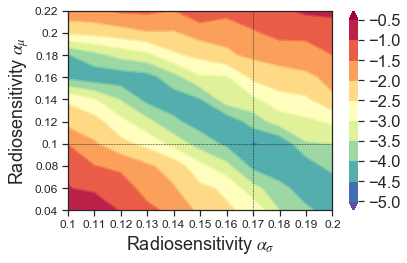

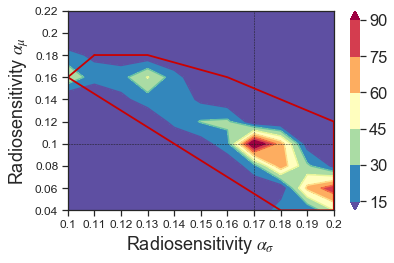

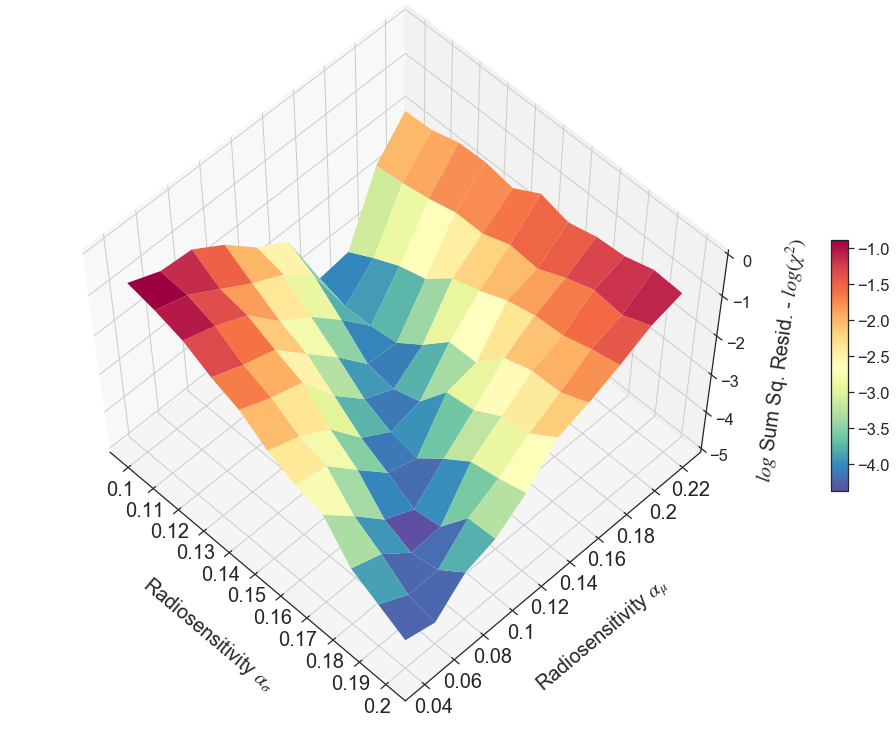

<Figure size 432x432 with 0 Axes>

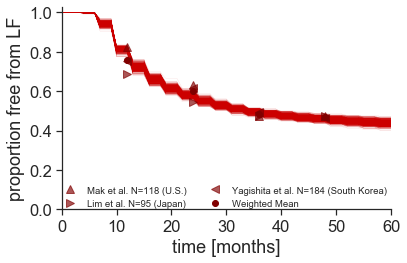

In [6]:
#####################################################################################              
# Analyze Calibration Simulations for Radiation Alpha_Sig and Alpha_Mu for Wild Type
##################################################################################### 
metOpt = 5 #optimal metastatic fraction 
rhoSigOpt = 5 #optimal growth sigma 
plot_MetSclRhoSig = True # load data for plotting
if plot_MetSclRhoSig:
    PatientResSaveCoMor_All = np.zeros([5*n_sample,3])
    for ialpha_mu in range(10):
        for ialpha_sig in range(11):
            for iiter in range(5):
                PatientResSaveCoMor = np.genfromtxt(pth+'/LRR_alphasig_alpharho/PatRes_iter{0}_metscl{1}_rhosig{2}_alphasig{3}_alphamu{4}.csv'.format(iiter,metOpt,rhoSigOpt,ialpha_sig,ialpha_mu), delimiter=',');
                PatientResSaveCoMor_All[iiter*n_sample:(iiter+1)*n_sample,:] = PatientResSaveCoMor
                
                LRR_comor = Calc_Cumulative_Curve(PatientResSaveCoMor_All[:,0])                    
                ChiSq_LRR_fitAlpha[ialpha_mu,ialpha_sig] = np.sum(((LRR_comor[Trial_T]-Trial_LRR)/Trial_LRR)**2)
            
            # boot strapping confidence intervals
            # run 1000 iterations and radnomly sub-sample 1/10 of of samples (half of n_sample with 5 iterations, 512 in paper for 1024 samples*5 iteration = 5120 total)
            for iiter in range(1000):
                LRR_comor1000 = Calc_Cumulative_Curve(PatientResSaveCoMor_All[list(index1000[0:int(n_sample/2),iiter].astype(int)),0])                    
                All_LRR_fitAlpha1000[ialpha_mu,ialpha_sig,iiter,:] = LRR_comor1000
                ChiSq_LRR_fitAlpha1000[ialpha_mu,ialpha_sig,iiter] = np.sum(((LRR_comor1000[Trial_T]-Trial_LRR)/Trial_LRR)**2)
    
    # determine the global optimum parameter and load data for this parameter            
    [alphaMuOpt,alphaSigOpt]=np.where(ChiSq_LRR_fitAlpha==np.min(ChiSq_LRR_fitAlpha))
    display('alphaMuOpt = {0}'.format(alphaMuOpt))
    display('alphaSigOpt = {0}'.format(alphaSigOpt))
    for iiter in range(5):
        PatientResSaveCoMor = np.genfromtxt(pth+'/LRR_alphasig_alpharho/PatRes_iter{0}_metscl{1}_rhosig{2}_alphasig{3}_alphamu{4}.csv'.format(iiter,metOpt,rhoSigOpt,int(alphaSigOpt),int(alphaMuOpt)), delimiter=',');
        PatientResSaveCoMor_All[iiter*n_sample:(iiter+1)*n_sample,:] = PatientResSaveCoMor
    
    # boot strapping 95% confidence intervals
    # find nearest 950 of 1000 iterations to global optimum and calculate convex hull
    Cenlrr1000 = np.where(ChiSq_LRR_fitAlpha==np.min(ChiSq_LRR_fitAlpha))                 
    Distlrr1000 = np.zeros([1000,1])                                            
    lrr1000 = np.zeros([1000,2])
    for iiter in range(1000):
        ind = np.where(ChiSq_LRR_fitAlpha1000[:,:,iiter]==np.min(ChiSq_LRR_fitAlpha1000[:,:,iiter]))
        lrr1000[iiter,0] = ind[0][0]
        lrr1000[iiter,1] = ind[1][0]
        Distlrr1000[iiter] = np.sum((lrr1000[iiter,:]-np.transpose(Cenlrr1000))**2)**0.5
    indx = np.argsort(Distlrr1000,axis=0)
    points = np.transpose(np.array([alpha_sig_var[list(lrr1000[:,1].astype(int))],alpha_mu_var[list(lrr1000[:,0].astype(int))]]))                                        
    points95 = np.squeeze(points[indx[0:950],:]);
    hull95 = sc.spatial.ConvexHull(points95)
    
    # K-P plot of model data at global optimum parameters
    plt.figure(figsize=[6,6])
    with seaborn.axes_style("ticks"):
        seaborn.set(style='ticks',font_scale=1.5)
        fig,ax = plt.subplots()
        plt.plot(Trial_T,Trial_LRR_I,'^',color='maroon',label='Mak et al. N=118 (U.S.)',alpha=0.66,markersize=8)
        plt.plot(Trial_T,Trial_LRR_II,'>',color='maroon',label='Lim et al. N=95 (Japan)',alpha=0.66,markersize=8)
        plt.plot(Trial_T,Trial_LRR_III,'<',color='maroon',label='Yagishita et al. N=184 (South Korea)',alpha=0.66,markersize=8)
        plt.plot(Trial_T,Trial_LRR,'o',color='maroon',label='Weighted Mean',markersize=6)
        kmf.fit(PatientResSaveCoMor_All[:,0],event_observed=PatientResSaveCoMor_All[:,0]<60,label='Model Prediction (WT)',alpha=1-0.95)
        ax = kmf.plot(ax=ax,color = 'maroon')
        plt.xlim([0,60])
        plt.ylim([0,1.025])
        ax.legend(loc=[0.3,-0.015],prop={'size': 11.2},ncol=1,frameon=False)
        plt.xlabel('time [months]')
        plt.ylabel('proportion free from LF')
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        plt.tight_layout()  

    # Model data at global optimum parameters vs Literature Data
    ModVsTrial_LRR = np.zeros(4)
    for imo in range(4):
        ind = np.where(kmf.timeline>=(imo+1)*12)[0][0]
        ModVsTrial_LRR[imo]=np.array(kmf.survival_function_)[ind]
    slope, intercept, r_value, p_value, std_err = sc.stats.linregress(ModVsTrial_LRR, Trial_LRR)
    plt.figure(figsize=[6,6])
    with seaborn.axes_style("ticks"):
        seaborn.set(style='ticks',font_scale=1.5)
        fig,ax = plt.subplots()                            
        plt.plot(ModVsTrial_LRR,Trial_LRR,'o-',color = 'maroon')
        plt.plot(ModVsTrial_LRR,Trial_LRR_I,'^',color='maroon',alpha=0.66,markersize=8)
        plt.plot(ModVsTrial_LRR,Trial_LRR_II,'>',color='maroon',alpha=0.66,markersize=8)
        plt.plot(ModVsTrial_LRR,Trial_LRR_III,'<',color='maroon',alpha=0.66,markersize=8)
        plt.plot([0.3,0.9],[0.3,0.9],'k--')
        plt.xticks([0.4,0.5,0.6,0.7,0.8,0.9],[0.4,0.5,0.6,0.7,0.8,0.9])
        plt.yticks([0.4,0.5,0.6,0.7,0.8,0.9],[0.4,0.5,0.6,0.7,0.8,0.9])
        plt.xlabel('model predicted \n proportion free from LF')
        plt.ylabel('literature reported \n proportion free from LF')
        plt.text(0.3+0.6*0.025,0.3+0.6*0.775,'$r^2 =$' + str(round(r_value**2,3)),fontsize=12)
        plt.text(0.3+0.6*0.025,0.3+0.6*0.85,'$p =$ {0}'.format(round(p_value,3)),fontsize=12)
        plt.axis([0.3,0.9,0.3,0.9])
        ax.set_aspect('equal', 'box')
        plt.tight_layout()  
    
    # 2D countour of Chi Sq goodness of fit over entire model parameter space                                         
    Y = np.array(alpha_mu_var[0:10])
    X = np.array(alpha_sig_var[0:11])                                         
    fig, ax = plt.subplots()
    ax.plot([alpha_sig_var[int(alphaSigOpt)],alpha_sig_var[int(alphaSigOpt)]],[alpha_mu_var[0],alpha_mu_var[9]],'--k',linewidth=0.5)
    ax.plot([alpha_sig_var[0],alpha_sig_var[10]],[alpha_mu_var[int(alphaMuOpt)],alpha_mu_var[int(alphaMuOpt)]],'--k',linewidth=0.5)
    CS1=ax.contourf(X, Y, np.log(ChiSq_LRR_fitAlpha),np.arange(-5,0,0.5),cmap=cm.Spectral_r,extend='both')
    CS2=ax.contour(X, Y, np.log(ChiSq_LRR_fitAlpha),np.arange(-5,0,0.5),cmap=cm.Spectral_r,extend='both')
    cbar = plt.colorbar(CS1, ax=ax)
    cbar.outline.set_visible(False)
    plt.ylabel(r'Radiosensitivity $\alpha_{\mu}$')
    plt.xlabel(r'Radiosensitivity $\alpha_{\sigma}$')
    ax.set_yticks(np.round(alpha_mu_var[0:10],4))
    ax.set_xticks(np.round(alpha_sig_var[0:11],4))
    ax.set_xticklabels(np.round(alpha_sig_var[0:11],4), fontsize=12)
    ax.set_yticklabels(np.round(alpha_mu_var[0:10],4),fontsize=12)
    fig.tight_layout()                                          
    
    # 2D histogram of optimal parameters and 95% convex hull (confidence interval)
    fig, ax = plt.subplots()
    hist2D = plt.hist2d(alpha_mu_var[list(lrr1000[:,0].astype(int))],alpha_sig_var[list(lrr1000[:,1].astype(int))],[np.append(Y-0.001,max(Y)+0.001),np.append(X-0.001,max(X)+0.001)])
    plt.close()
    fig, ax = plt.subplots()
    ax.plot([alpha_sig_var[7],alpha_sig_var[7]],[alpha_mu_var[0],alpha_mu_var[9]],'--k',linewidth=0.5)
    ax.plot([alpha_sig_var[0],alpha_sig_var[10]],[alpha_mu_var[3],alpha_mu_var[3]],'--k',linewidth=0.5)
    CS1=ax.contourf(X, Y, hist2D[0],np.arange(15,105,15),cmap=cm.Spectral_r,extend='both')
    CS2=ax.contour(X, Y, hist2D[0],np.arange(15,105,15),cmap=cm.Spectral_r,extend='both')
    cbar = plt.colorbar(CS1, ax=ax)
    cbar.outline.set_visible(False)
    ax.plot(points95[hull95.vertices,0], points95[hull95.vertices,1], '-',color=[0.8,0,0,1], lw=1.8);
    ax.plot([points95[hull95.vertices[len(hull95.vertices)-1],0],points95[hull95.vertices[0],0]], [points95[hull95.vertices[len(hull95.vertices)-1],1],points95[hull95.vertices[0],1]], '-', color=[0.8,0,0,1], lw=1.8)
    plt.ylabel(r'Radiosensitivity $\alpha_{\mu}$')
    plt.xlabel(r'Radiosensitivity $\alpha_{\sigma}$')
    ax.set_yticks(np.round(alpha_mu_var[0:10],4))
    ax.set_xticks(np.round(alpha_sig_var[0:11],4))
    ax.set_xticklabels(np.round(alpha_sig_var[0:11],4), fontsize=12)
    ax.set_yticklabels(np.round(alpha_mu_var[0:10],4),fontsize=12)
    fig.tight_layout() 
    
    # 3D surface of Chi Sq goodness of fit over entire model parameter space 
    fig = plt.figure(figsize=[14,10.5])
    ax = fig.gca(projection='3d')
    X, Y = np.meshgrid(X, Y)
    surf = ax.plot_surface(X, Y, np.log(ChiSq_LRR_fitAlpha), cmap=cm.Spectral_r,linewidth=0, antialiased=True)           
    ax.set_zlim(-5, 0)
    ax.set_yticks(np.round(alpha_mu_var[0:10],4))
    ax.set_xticks(np.round(alpha_sig_var[0:11],4))
    ax.set_xticklabels(np.round(alpha_sig_var[0:11],4), fontsize=20)
    ax.set_yticklabels(np.round(alpha_mu_var[0:10],4),fontsize=20)
    fig.colorbar(surf, shrink=0.35, aspect=15)
    ax.view_init(60, 315)
    ax.set_ylabel('\n'r'Radiosensitivity $\alpha_{\mu}$',linespacing=5, fontsize=20)
    ax.set_xlabel('\n'r'Radiosensitivity $\alpha_{\sigma}$',linespacing=5, fontsize=20) 
    ax.set_zlabel('\n'r'$log$ Sum Sq. Resid. - $log(\chi^{2})$',linespacing=3, fontsize=20) 
    fig.tight_layout()                                          
    
    # plot of 1000 radomly subsampled K-P curves
    plt.figure(figsize=[6,6])
    with seaborn.axes_style("ticks"):
        seaborn.set(style='ticks',font_scale=1.5)
        fig,ax = plt.subplots()
        for iiter in range(1000):
            plt.plot(All_LRR_fitAlpha1000[int(lrr1000[iiter,0]),int(lrr1000[iiter,1]),iiter,:],color=[0.8,0,0,1],linewidth = 0.05)
        plt.plot(Trial_T,Trial_LRR_I,'^',color='maroon',label='Mak et al. N=118 (U.S.)',alpha=0.66,markersize=8)
        plt.plot(Trial_T,Trial_LRR_II,'>',color='maroon',label='Lim et al. N=95 (Japan)',alpha=0.66,markersize=8)
        plt.plot(Trial_T,Trial_LRR_III,'<',color='maroon',label='Yagishita et al. N=184 (South Korea)',alpha=0.66,markersize=8)
        plt.plot(Trial_T,Trial_LRR,'o',color='maroon',label='Weighted Mean',markersize=6)
        plt.xlim([0,60])
        plt.ylim([0,1.025])
        ax.legend(loc=[-0.015,-0.015],prop={'size': 9.5},ncol=2,frameon=False)
        plt.xlabel('time [months]')
        plt.ylabel('proportion free from LF')
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        plt.tight_layout()                                         
                                                                                  

'alphaMuEGFROpt = [6]'

'alphaSigEGFROpt = [14]'

<Figure size 432x432 with 0 Axes>

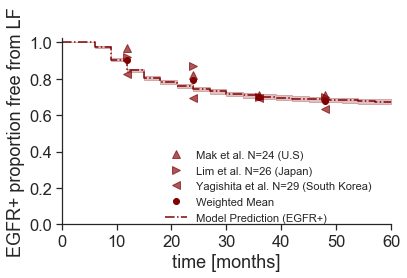

<Figure size 432x432 with 0 Axes>

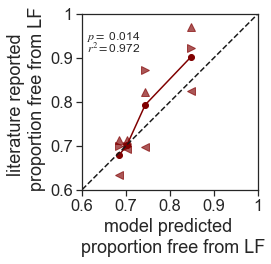

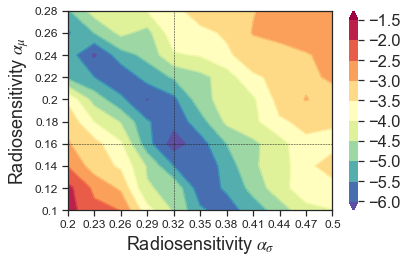

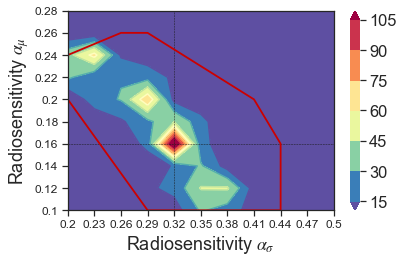

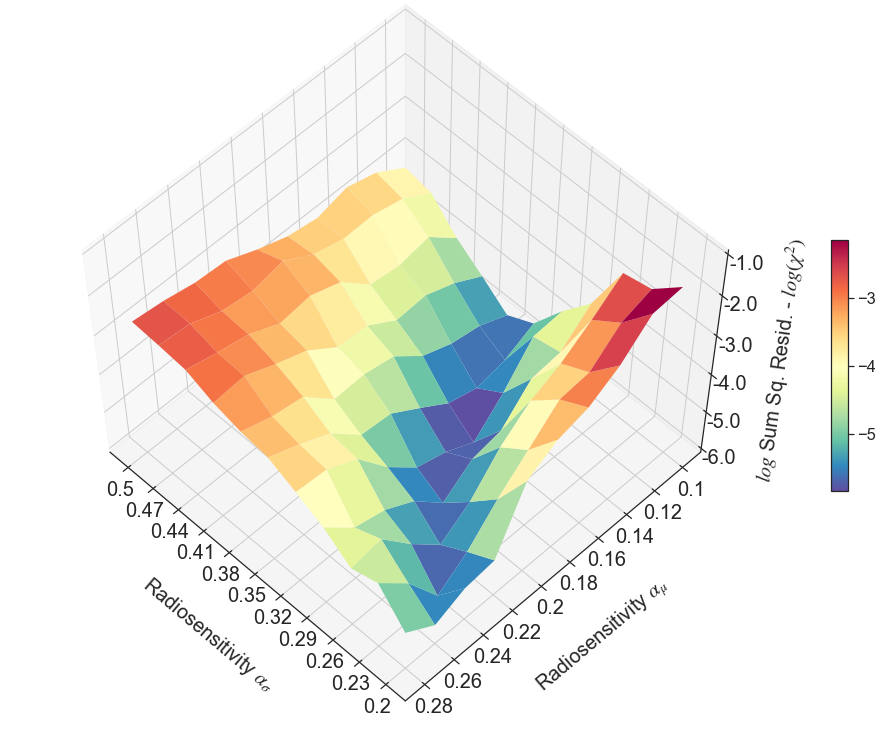

<Figure size 432x432 with 0 Axes>

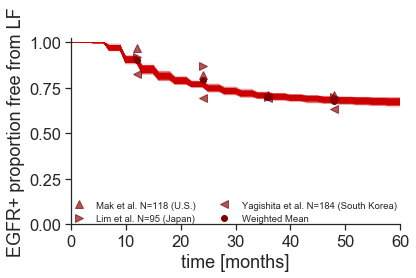

In [7]:
####################################################################################               
# Analyze Calibration Simulations for Radiation Alpha_Sig and Alpha_Mu for EGFR mut
####################################################################################  
metOpt = 5 #optimal metastatic fraction 
rhoSigOpt = 5 #optimal growth sigma 
plot_MetSclRhoSig = True # load data for plotting
if plot_MetSclRhoSig:
    PatientResSaveCoMor_All = np.zeros([5*n_sample,3])
    for ialpha_mu in range(3,len(alpha_mu_var)):
        for ialpha_sig in range(10,len(alpha_sig_var)):            
            for iiter in range(5):
                PatientResSaveCoMor = np.genfromtxt(pth+'/LRR_EGFR_alphasig_alpharho/PatRes_iter{0}_metscl{1}_rhosig{2}_alphasig{3}_alphamu{4}.csv'.format(iiter,metOpt,rhoSigOpt,ialpha_sig,ialpha_mu), delimiter=',');
                PatientResSaveCoMor_All[iiter*n_sample:(iiter+1)*n_sample,:] = PatientResSaveCoMor

                LRR_EGFR_comor = Calc_Cumulative_Curve(PatientResSaveCoMor_All[:,0])                    
                ChiSq_LRR_fitAlphaEGFR[ialpha_mu-3,ialpha_sig-10] = np.sum(((LRR_EGFR_comor[Trial_T]-Trial_LRR_EGFR)/Trial_LRR_EGFR)**2)
            
            # boot strapping confidence intervals
            # run 1000 iterations and radnomly sub-sample 1/10 of of samples (half of n_sample with 5 iterations, 512 in paper for 1024 samples*5 iteration = 5120 total)
            for iiter in range(1000):
                LRR_EGFR_comor1000 = Calc_Cumulative_Curve(PatientResSaveCoMor_All[list(index1000[0:int(n_sample/2),iiter].astype(int)),0])                    
                All_LRR_fitAlphaEGFR1000[ialpha_mu-3,ialpha_sig-10,iiter,:] = LRR_EGFR_comor1000
                ChiSq_LRR_fitAlphaEGFR1000[ialpha_mu-3,ialpha_sig-10,iiter] = np.sum(((LRR_EGFR_comor1000[Trial_T]-Trial_LRR_EGFR)/Trial_LRR_EGFR)**2)              
    
    # determine the global optimum parameter and load data for this parameter
    [alphaMuEGFROpt,alphaSigEGFROpt]=np.where(ChiSq_LRR_fitAlphaEGFR==np.min(ChiSq_LRR_fitAlphaEGFR))
    display('alphaMuEGFROpt = {0}'.format(alphaMuEGFROpt+3))
    display('alphaSigEGFROpt = {0}'.format(alphaSigEGFROpt+10))
    for iiter in range(5):
        PatientResSaveCoMor = np.genfromtxt(pth+'/LRR_EGFR_alphasig_alpharho/PatRes_iter{0}_metscl{1}_rhosig{2}_alphasig{3}_alphamu{4}.csv'.format(iiter,metOpt,rhoSigOpt,int(alphaSigEGFROpt+10),int(alphaMuEGFROpt+3)), delimiter=',');
        PatientResSaveCoMor_All[iiter*n_sample:(iiter+1)*n_sample,:] = PatientResSaveCoMor
        
    # boot strapping 95% confidence intervals
    # find nearest 950 of 1000 iterations to global optimum and calculate convex hull
    CenlrrEGFR1000 = np.where(ChiSq_LRR_fitAlphaEGFR==np.min(ChiSq_LRR_fitAlphaEGFR))                 
    DistlrrEGFR1000 = np.zeros([1000,1])
    lrrEGFR1000 = np.zeros([1000,2])
    for iiter in range(1000):
        ind = np.where(ChiSq_LRR_fitAlphaEGFR1000[:,:,iiter]==np.min(ChiSq_LRR_fitAlphaEGFR1000[:,:,iiter]))
        lrrEGFR1000[iiter,0] = ind[0][0]
        lrrEGFR1000[iiter,1] = ind[1][0]
        DistlrrEGFR1000[iiter] = np.sum((lrrEGFR1000[iiter,:]-np.transpose(CenlrrEGFR1000))**2)**0.5
    indx = np.argsort(DistlrrEGFR1000,axis=0)
    points = np.transpose(np.array([alpha_sig_var[list(lrrEGFR1000[:,1].astype(int)+10)],alpha_mu_var[list(lrrEGFR1000[:,0].astype(int)+3)]]))
    points95 = np.squeeze(points[indx[0:950],:]);
    hull95 = sc.spatial.ConvexHull(points95)
    
    # K-P plot of model data at global optimum parameters
    plt.figure(figsize=[6,6])
    with seaborn.axes_style("ticks"):
        seaborn.set(style='ticks',font_scale=1.5)
        fig,ax = plt.subplots()
        plt.plot(Trial_T,Trial_LRR_EGFR_I,'^',color='maroon',label='Mak et al. N=24 (U.S)',alpha=0.66,markersize=8)
        plt.plot(Trial_T,Trial_LRR_EGFR_II,'>',color='maroon',label='Lim et al. N=26 (Japan)',alpha=0.66,markersize=8)
        plt.plot(Trial_T,Trial_LRR_EGFR_III,'<',color='maroon',label='Yagishita et al. N=29 (South Korea)',alpha=0.66,markersize=8)
        plt.plot(Trial_T,Trial_LRR_EGFR,'o',color='maroon',label='Weighted Mean',markersize=6)
        kmf.fit(PatientResSaveCoMor_All[:,0],event_observed=PatientResSaveCoMor_All[:,0]<60,label='Model Prediction (EGFR+)',alpha=1-0.95)
        ax = kmf.plot(ax=ax,color = 'maroon',linestyle = '-.')
        plt.xlim([0,60])
        plt.ylim([0,1.025])
        ax.legend(loc=[0.3,-0.015],prop={'size': 11.2},ncol=1,frameon=False)
        plt.yticks([0,0.2,0.4,0.6,0.8,1])
        plt.xlabel('time [months]')
        plt.ylabel('EGFR+ proportion free from LF')
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        plt.tight_layout()  

    # Model data at global optimum parameters vs Literature Data
    ModVsTrial_LRR_EGFR = np.zeros(4)
    for imo in range(4):
        ind = np.where(kmf.timeline>=(imo+1)*12)[0][0]
        ModVsTrial_LRR_EGFR[imo]=np.array(kmf.survival_function_)[ind]
    slope, intercept, r_value, p_value, std_err = sc.stats.linregress(ModVsTrial_LRR_EGFR, Trial_LRR_EGFR)
    plt.figure(figsize=[6,6])
    with seaborn.axes_style("ticks"):
        seaborn.set(style='ticks',font_scale=1.5)
        fig,ax = plt.subplots()                            
        plt.plot(ModVsTrial_LRR_EGFR,Trial_LRR_EGFR_I,'^',color='maroon',alpha=0.66,markersize=8)
        plt.plot(ModVsTrial_LRR_EGFR,Trial_LRR_EGFR_II,'>',color='maroon',alpha=0.66,markersize=8)
        plt.plot(ModVsTrial_LRR_EGFR,Trial_LRR_EGFR_III,'<',color='maroon',alpha=0.66,markersize=8)
        plt.plot(ModVsTrial_LRR_EGFR,Trial_LRR_EGFR,'o-',color = 'maroon')
        plt.plot([0.6,1],[0.6,1],'k--')
        plt.xticks([0.6,0.7,0.8,0.9,1],[0.6,0.7,0.8,0.9,1])
        plt.yticks([0.6,0.7,0.8,0.9,1],[0.6,0.7,0.8,0.9,1])
        plt.xlabel('model predicted \n proportion free from LF')
        plt.ylabel('literature reported \n proportion free from LF')
        plt.text(0.6+0.4*0.025,0.6+0.4*0.775,'$r^2 =$' + str(round(r_value**2,3)),fontsize=12)
        plt.text(0.6+0.4*0.025,0.6+0.4*0.85,'$p =$ {0}'.format(round(p_value,3)),fontsize=12)
        plt.axis([0.6,1,0.6,1])
        ax.set_aspect('equal', 'box')
        plt.tight_layout()  

    # 2D countour of Chi Sq goodness of fit over entire model parameter space 
    Y = alpha_mu_var[3:]
    X = alpha_sig_var[10:]
    fig, ax = plt.subplots()
    ax.plot([alpha_sig_var[14],alpha_sig_var[14]],[alpha_mu_var[3],alpha_mu_var[12]],'--k',linewidth=0.5)
    ax.plot([alpha_sig_var[10],alpha_sig_var[20]],[alpha_mu_var[6],alpha_mu_var[6]],'--k',linewidth=0.5)
    CS1=ax.contourf(X, Y, np.log(ChiSq_LRR_fitAlphaEGFR),np.arange(-6,-1,0.5),cmap=cm.Spectral_r,extend='both')
    CS2=ax.contour(X, Y, np.log(ChiSq_LRR_fitAlphaEGFR),np.arange(-6,-1,0.5),cmap=cm.Spectral_r,extend='both')
    cbar = plt.colorbar(CS1, ax=ax)
    cbar.outline.set_visible(False)
    plt.ylabel(r'Radiosensitivity $\alpha_{\mu}$')
    plt.xlabel(r'Radiosensitivity $\alpha_{\sigma}$')
    ax.set_yticks(np.round(alpha_mu_var[3:],4))
    ax.set_xticks(np.round(alpha_sig_var[10:],4))
    ax.set_xticklabels(np.round(alpha_sig_var[10:],4), fontsize=12)
    ax.set_yticklabels(np.round(alpha_mu_var[3:],4),fontsize=12)
    fig.tight_layout() 
    
    # 2D histogram of optimal parameters and 95% convex hull (confidence interval)
    fig, ax = plt.subplots()
    hist2D = plt.hist2d(alpha_mu_var[list(lrrEGFR1000[:,0].astype(int)+3)],alpha_sig_var[list(lrrEGFR1000[:,1].astype(int)+10)],[np.append(Y-0.001,max(Y)+0.001),np.append(X-0.001,max(X)+0.001)])
    plt.close()
    fig, ax = plt.subplots()
    ax.plot([alpha_sig_var[14],alpha_sig_var[14]],[alpha_mu_var[3],alpha_mu_var[12]],'--k',linewidth=0.5)
    ax.plot([alpha_sig_var[10],alpha_sig_var[20]],[alpha_mu_var[6],alpha_mu_var[6]],'--k',linewidth=0.5)
    CS1=ax.contourf(X, Y, np.array(hist2D[0]),np.arange(15,120,15),cmap=cm.Spectral_r,extend='both')
    CS2=ax.contour(X, Y, np.array(hist2D[0]),np.arange(15,120,15),cmap=cm.Spectral_r,extend='both')
    cbar = plt.colorbar(CS1, ax=ax)
    cbar.outline.set_visible(False)
    ax.plot(points95[hull95.vertices,0], points95[hull95.vertices,1], '-',color=[0.8,0,0,1], lw=1.8);
    ax.plot([points95[hull95.vertices[len(hull95.vertices)-1],0],points95[hull95.vertices[0],0]], [points95[hull95.vertices[len(hull95.vertices)-1],1],points95[hull95.vertices[0],1]], '-', color=[0.8,0,0,1], lw=1.8)
    plt.ylabel(r'Radiosensitivity $\alpha_{\mu}$')
    plt.xlabel(r'Radiosensitivity $\alpha_{\sigma}$')
    ax.set_yticks(np.round(alpha_mu_var[3:],4))
    ax.set_xticks(np.round(alpha_sig_var[10:],4))
    ax.set_xticklabels(np.round(alpha_sig_var[10:],4), fontsize=12)
    ax.set_yticklabels(np.round(alpha_mu_var[3:],4),fontsize=12)
    fig.tight_layout() 
    
    # 3D surface of Chi Sq goodness of fit over entire model parameter space 
    fig = plt.figure(figsize=[14,10.5])
    ax = fig.gca(projection='3d')
    X, Y = np.meshgrid(X, Y)
    surf = ax.plot_surface(X, Y, np.log(ChiSq_LRR_fitAlphaEGFR), cmap=cm.Spectral_r,linewidth=0, antialiased=True)           
    ax.set_zlim(-6, -1)
    ax.set_yticks(np.round(alpha_mu_var[3:],4))
    ax.set_xticks(np.round(alpha_sig_var[10:],4))
    ax.set_xticklabels(np.round(alpha_sig_var[10:],4), fontsize=20)
    ax.set_yticklabels(np.round(alpha_mu_var[3:],4),fontsize=20)
    ax.set_zticklabels(np.arange(-6, -0.9,1),fontsize=20)    
    fig.colorbar(surf, shrink=0.35, aspect=15)
    ax.view_init(60, 135)
    ax.set_ylabel('\n'r'Radiosensitivity $\alpha_{\mu}$',linespacing=5, fontsize=20)
    ax.set_xlabel('\n'r'Radiosensitivity $\alpha_{\sigma}$',linespacing=5, fontsize=20) 
    ax.set_zlabel('\n'r'$log$ Sum Sq. Resid. - $log(\chi^{2})$',linespacing=3, fontsize=20) 
    fig.tight_layout() 
    
    # plot of 1000 radomly subsampled K-P curves
    plt.figure(figsize=[6,6])
    with seaborn.axes_style("ticks"):
        seaborn.set(style='ticks',font_scale=1.5)
        fig,ax = plt.subplots()
        for iiter in range(1000):
            plt.plot(All_LRR_fitAlphaEGFR1000[int(lrrEGFR1000[iiter,0]),int(lrrEGFR1000[iiter,1]),iiter,:],color=[0.8,0,0,1],linewidth = 0.05)
        plt.plot(Trial_T,Trial_LRR_EGFR_I,'^',color='maroon',label='Mak et al. N=118 (U.S.)',alpha=0.66,markersize=8)
        plt.plot(Trial_T,Trial_LRR_EGFR_II,'>',color='maroon',label='Lim et al. N=95 (Japan)',alpha=0.66,markersize=8)
        plt.plot(Trial_T,Trial_LRR_EGFR_III,'<',color='maroon',label='Yagishita et al. N=184 (South Korea)',alpha=0.66,markersize=8)
        plt.plot(Trial_T,Trial_LRR_EGFR,'o',color='maroon',label='Weighted Mean',markersize=6)
        plt.xlim([0,60])
        plt.ylim([0,1.025])
        ax.legend(loc=[-0.015,-0.015],prop={'size': 9.5},ncol=2,frameon=False)
        plt.xlabel('time [months]')
        plt.ylabel('EGFR+ proportion free from LF')
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        plt.tight_layout()  
                                            